# 🇺🇸 Dependencies
---
# 🇮🇹 Dipendenze 

In [38]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
tqdm.pandas()

from sklearn import model_selection

from sentence_transformers import SentenceTransformer

# 🇺🇸 Import datasets
--- 
# 🇮🇹 Importazione dati 

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
sample_submission = pd.read_csv('./data/sample_submission.csv')

features = ["full_text"]
labels = ["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]

In [36]:
device = torch.device("mps:0" if torch.cuda.is_available() else "cpu")

# 🇺🇸 Exploratory Data Analysis (EDA)
--- 
# 🇮🇹 Analisi esplorativa del dato (EDA)

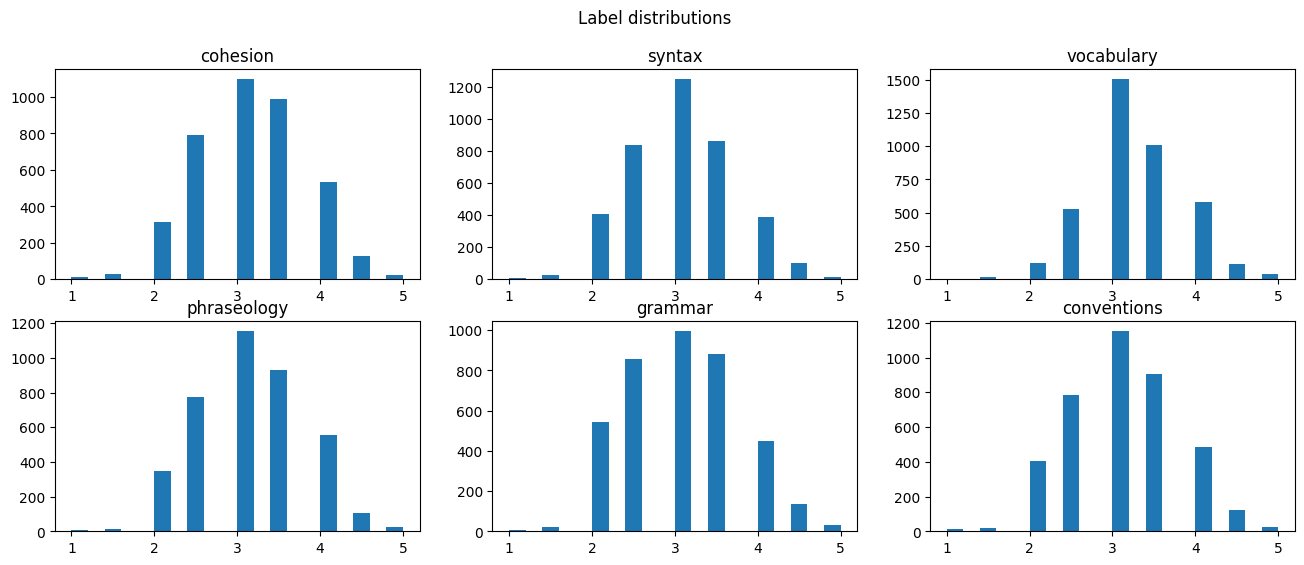

In [37]:
plt.figure(figsize=(16, 6))
for i, label in enumerate(labels):
    plt.subplot(2, 3, i + 1)
    plt.hist(train[label], bins=20)
    plt.title(label)

plt.suptitle("Label distributions")
plt.show()

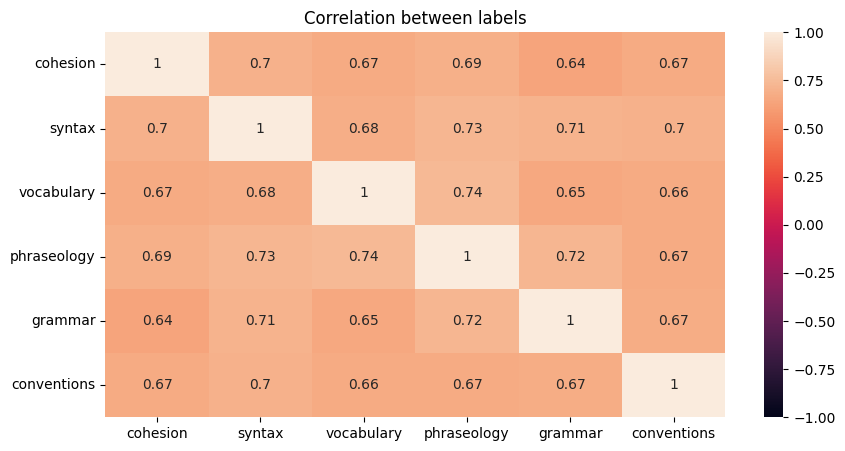

In [5]:
plt.figure(figsize=(10, 5))
sns.heatmap(train[labels].corr(), annot=True, square=False, vmin=-1, vmax=1)
plt.title("Correlation between labels")
plt.show()


# 🇺🇸 Split into train and validation sets

Application of PyTorch `Dataset` and `DataLoader` classes and text encoding.

--- 
# 🇮🇹 Divisione in set di addestramento e di validazione

Applicazione delle classi `Dataset` e `DataLoader` di PyTorch e encoding del testo.

In [6]:
x_train, x_val, y_train, y_val = model_selection.train_test_split(train[features].values, train[labels].values, test_size=0.2, random_state=42)
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(3128, 1) (783, 1) (3128, 6) (783, 6)


In [7]:
embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2', device="mps")

In [8]:
class EnglishLanguageProficiency(Dataset):
    def __init__(self, embeddings, cohesion, syntax, vocabulary, phraseology, grammar, conventions):
        self.features = torch.tensor(embeddings, dtype=torch.float32)
        self.cohesion = torch.tensor(cohesion, dtype=torch.float32)
        self.syntax = torch.tensor(syntax, dtype=torch.float32)
        self.vocabulary = torch.tensor(vocabulary, dtype=torch.float32)
        self.phraseology = torch.tensor(phraseology, dtype=torch.float32)
        self.grammar = torch.tensor(grammar, dtype=torch.float32)
        self.conventions = torch.tensor(conventions, dtype=torch.float32)

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        x = self.features[idx]
        y = torch.stack([
            self.cohesion[idx],
            self.syntax[idx],
            self.vocabulary[idx],
            self.phraseology[idx],
            self.grammar[idx],
            self.conventions[idx]
        ])
        return {
            'x': x,
            'y': y
        }

In [9]:
train_embeddings = embedding_model.encode(x_train[:, 0], batch_size=200, show_progress_bar=True, device=device)
val_embeddings = embedding_model.encode(x_val[:, 0], batch_size=200, show_progress_bar=True, device=device)
test_embeddings = embedding_model.encode(test[features].values[:, 0], batch_size=200, show_progress_bar=True)

Batches: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


In [10]:
train_embeddings

array([[-0.09318926,  0.00423619,  0.02815985, ...,  0.00752447,
        -0.06652465, -0.02501139],
       [ 0.04237603, -0.02704737,  0.01021558, ...,  0.05896651,
        -0.13489658,  0.02803236],
       [ 0.02641385,  0.04102813, -0.08502118, ..., -0.00755973,
        -0.0864008 ,  0.01873737],
       ...,
       [ 0.05361762,  0.05990427,  0.00647471, ...,  0.06769853,
        -0.07111193,  0.05109518],
       [ 0.03240207, -0.03758994,  0.07875723, ...,  0.01599755,
        -0.12521371,  0.04028842],
       [ 0.00951448,  0.08904066,  0.0581084 , ...,  0.05006377,
        -0.08251362, -0.00287952]], dtype=float32)

In [11]:
train_dataset = EnglishLanguageProficiency(train_embeddings, y_train[:, 0], y_train[:, 1], y_train[:, 2], y_train[:, 3], y_train[:, 4], y_train[:, 5])
val_dataset = EnglishLanguageProficiency(val_embeddings, y_val[:, 0], y_val[:, 1], y_val[:, 2], y_val[:, 3], y_val[:, 4], y_val[:, 5])

In [12]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=True,
    drop_last=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=16,
    shuffle=False,
    drop_last=True
)

# 🇺🇸 Modeling and training with PyTorch

Creation of a simple regression model in PyTorch

--- 
# 🇮🇹 Modellazione e addestramento con PyTorch

Creazione di un semplice modello di regressione in PyTorch

In [13]:
class RegressionModel(nn.Module):
    def __init__(self, n_features, n_outputs):
        super().__init__()
        self.n_features = n_features
        self.n_outputs = n_outputs

        self.cohesion_layer = nn.Linear(self.n_features, self.n_outputs)
        self.syntax_layer = nn.Linear(self.n_features, self.n_outputs)
        self.vocabulary_layer = nn.Linear(self.n_features, self.n_outputs)
        self.phraseology_layer = nn.Linear(self.n_features, self.n_outputs)
        self.grammar_layer = nn.Linear(self.n_features, self.n_outputs)
        self.conventions_layer = nn.Linear(self.n_features, self.n_outputs)

    def forward(self, x):
        cohesion = self.cohesion_layer(x)
        syntax = self.syntax_layer(x)
        vocabulary = self.vocabulary_layer(x)
        phraseology = self.phraseology_layer(x)
        grammar = self.grammar_layer(x)
        conventions = self.conventions_layer(x)
        return torch.cat([cohesion, syntax, vocabulary, phraseology, grammar, conventions], dim=1)

 20%|██        | 6/30 [00:00<00:02,  9.01it/s]

Epoch: 5/30, Train Loss: 0.630, Val Loss: 0.617, Train RMSE: 0.794, Val RMSE: 0.786


 37%|███▋      | 11/30 [00:01<00:02,  9.16it/s]

Epoch: 10/30, Train Loss: 0.501, Val Loss: 0.492, Train RMSE: 0.708, Val RMSE: 0.701


 53%|█████▎    | 16/30 [00:01<00:01,  9.18it/s]

Epoch: 15/30, Train Loss: 0.433, Val Loss: 0.431, Train RMSE: 0.658, Val RMSE: 0.657


 70%|███████   | 21/30 [00:02<00:00,  9.24it/s]

Epoch: 20/30, Train Loss: 0.393, Val Loss: 0.398, Train RMSE: 0.627, Val RMSE: 0.631


 87%|████████▋ | 26/30 [00:02<00:00,  9.24it/s]

Epoch: 25/30, Train Loss: 0.367, Val Loss: 0.376, Train RMSE: 0.606, Val RMSE: 0.613


100%|██████████| 30/30 [00:03<00:00,  9.11it/s]

Epoch: 30/30, Train Loss: 0.349, Val Loss: 0.362, Train RMSE: 0.591, Val RMSE: 0.601


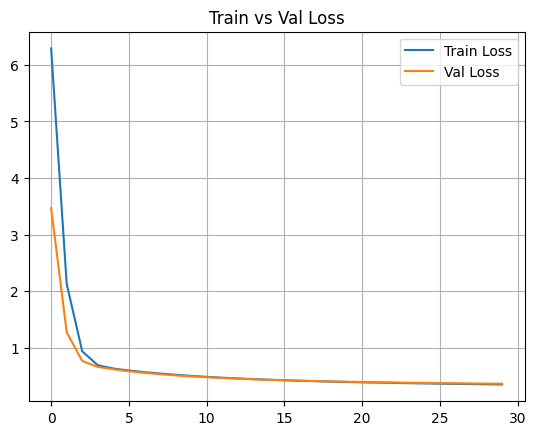

In [20]:
model = RegressionModel(n_features=train_embeddings.shape[1], n_outputs=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.1, verbose=True)
criterion = nn.MSELoss()

epoch_train_losses = []
epoch_val_losses = []
epoch_train_rmse = []
epoch_val_rmse = []

num_epochs = 30

for epoch in tqdm(range(num_epochs)):
    train_losses = []
    val_losses = []
    
    model = model.train()

    for data in train_loader:
        x = data['x']
        y = data['y']
        y_pred = model(x)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    model = model.eval()

    for data in val_loader:
        x = data['x']
        y = data['y']
        y_pred = model(x)
        loss = criterion(y_pred, y)
        val_losses.append(loss.item())

    epoch_train_losses.append(np.mean(train_losses))
    epoch_val_losses.append(np.mean(val_losses))
    epoch_train_rmse.append(np.sqrt(np.mean(train_losses)))
    epoch_val_rmse.append(np.sqrt(np.mean(val_losses)))

    scheduler.step(np.mean(val_losses))

    if (epoch+1) % 5 == 0:
        print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {np.mean(train_losses):.3f}, Val Loss: {np.mean(val_losses):.3f}, Train RMSE: {np.sqrt(np.mean(train_losses)):.3f}, Val RMSE: {np.sqrt(np.mean(val_losses)):.3f}")

plt.title("Train vs Val Loss")
plt.plot(epoch_train_losses, label="Train Loss")
plt.plot(epoch_val_losses, label="Val Loss")
plt.legend()
plt.grid()
plt.show()

# 🇺🇸 Inference on new data

Create predictions on unseen data

--- 
# 🇮🇹 Inferenza su dati nuovi

Creazione di predizioni su dati nuovi

In [32]:
with torch.inference_mode():
    test_preds = model(torch.tensor(test_embeddings, dtype=torch.float32))
test_preds = test_preds.numpy()
test_preds = pd.DataFrame(test_preds, columns=labels)
# test_preds.to_csv('./data/test_preds.csv', index=False)

In [35]:
test.merge(test_preds, left_index=True, right_index=True)

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,when a person has no experience on a job their...,3.045170,2.773664,3.228038,3.066814,2.674639,2.865695
1,000BAD50D026,Do you think students would benefit from being...,2.519142,2.358919,2.533441,2.293675,2.272622,2.608504
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde...",3.219418,3.076323,3.371208,3.097359,3.047671,3.180531
